# [参考サイトの写像みたいな物](https://github.com/yjn870/FSRCNN-pytorch/blob/master/test.py)

In [1]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import numpy as np
from PIL import Image
from collections import OrderedDict
import matplotlib.pyplot as plt

# モデル定義 

In [2]:
class FSRCNN(nn.Module):
    def __init__(self, scale_factor):
        super(FSRCNN, self).__init__()
        self.first_layer = nn.Sequential(OrderedDict([
            ("fl_conv",nn.Conv2d(1,56,kernel_size=5,padding = 2)),
            ("fl_PReLU",nn.PReLU(56))
        ]))
        
        self.middle_layer =nn.Sequential(OrderedDict([
            ("ml_conv1",nn.Conv2d(56,12,kernel_size=1)),
            ("ml_PReLU1",nn.PReLU(12)),
            
            ("ml_conv2",nn.Conv2d(12,12,kernel_size=3,padding=1)),
            ("ml_PReLU2",nn.PReLU(12)),
            
            ("ml_conv3",nn.Conv2d(12,12,kernel_size=3,padding=1)),
            ("ml_PReLU3",nn.PReLU(12)),
            
            ("ml_conv4",nn.Conv2d(12,12,kernel_size=3,padding=1)),
            ("ml_PReLU4",nn.PReLU(12)),
            
            ("ml_conv5",nn.Conv2d(12,12,kernel_size=3,padding=1)),
            ("ml_PReLU5",nn.PReLU(12)),
            
            ("ml_conv6",nn.Conv2d(12,56,kernel_size=1)),
            ("ml_PReLU6",nn.PReLU(56)),
        ]))
        
        self.last_layer = nn.Sequential(OrderedDict([
            ("ll_Deconv",nn.ConvTranspose2d(56,1,
                                            kernel_size=9,stride=scale_factor,padding=4,output_padding=scale_factor-1))
        ]))

        nn.init.normal_(self.first_layer.fl_conv.weight, 0.0, 0.0378)
        nn.init.zeros_(self.first_layer.fl_conv.bias.data)
        nn.init.normal_(self.middle_layer.ml_conv1.weight, 0.0, 0.3536)
        nn.init.zeros_(self.middle_layer.ml_conv1.bias.data)
        nn.init.normal_(self.middle_layer.ml_conv2.weight, 0.0, 0.1179)
        nn.init.zeros_(self.middle_layer.ml_conv2.bias.data)
        nn.init.normal_(self.middle_layer.ml_conv3.weight, 0.0, 0.1179)
        nn.init.zeros_(self.middle_layer.ml_conv3.bias.data)
        nn.init.normal_(self.middle_layer.ml_conv4.weight, 0.0, 0.1179)
        nn.init.zeros_(self.middle_layer.ml_conv4.bias.data)
        nn.init.normal_(self.middle_layer.ml_conv5.weight, 0.0, 0.1179)
        nn.init.zeros_(self.middle_layer.ml_conv5.bias.data)
        nn.init.normal_(self.middle_layer.ml_conv6.weight, 0.0, 0.189)
        nn.init.zeros_(self.middle_layer.ml_conv6.bias.data)
        nn.init.normal_(self.last_layer.ll_Deconv.weight, 0.0, 0.001)
        nn.init.zeros_(self.last_layer.ll_Deconv.bias.data)
        
    def forward(self,x):
        x = self.first_layer(x)
        x = self.middle_layer(x)
        x = self.last_layer(x)
        return x

# 使う関数定義

In [3]:
def convert_rgb_to_ycbcr(img, dim_order='hwc'):
    if dim_order == 'hwc':
        y = 16. + (64.738 * img[..., 0] + 129.057 * img[..., 1] + 25.064 * img[..., 2]) / 256.
        cb = 128. + (-37.945 * img[..., 0] - 74.494 * img[..., 1] + 112.439 * img[..., 2]) / 256.
        cr = 128. + (112.439 * img[..., 0] - 94.154 * img[..., 1] - 18.285 * img[..., 2]) / 256.
    else:
        y = 16. + (64.738 * img[0] + 129.057 * img[1] + 25.064 * img[2]) / 256.
        cb = 128. + (-37.945 * img[0] - 74.494 * img[1] + 112.439 * img[2]) / 256.
        cr = 128. + (112.439 * img[0] - 94.154 * img[1] - 18.285 * img[2]) / 256.
    return np.array([y, cb, cr]).transpose([1, 2, 0])

In [4]:
def convert_ycbcr_to_rgb(img, dim_order='hwc'):
    if dim_order == 'hwc':
        r = 298.082 * img[..., 0] / 256. + 408.583 * img[..., 2] / 256. - 222.921
        g = 298.082 * img[..., 0] / 256. - 100.291 * img[..., 1] / 256. - 208.120 * img[..., 2] / 256. + 135.576
        b = 298.082 * img[..., 0] / 256. + 516.412 * img[..., 1] / 256. - 276.836
    else:
        r = 298.082 * img[0] / 256. + 408.583 * img[2] / 256. - 222.921
        g = 298.082 * img[0] / 256. - 100.291 * img[1] / 256. - 208.120 * img[2] / 256. + 135.576
        b = 298.082 * img[0] / 256. + 516.412 * img[1] / 256. - 276.836
    return np.array([r, g, b]).transpose([1, 2, 0])

#### [...について](https://note.nkmk.me/python-numpy-ellipsis/)

In [5]:
def preprocess(img, device):
    img = np.array(img).astype(np.float32) #imgをnp.array型でfloat32型の配列に変換
    ycbcr = convert_rgb_to_ycbcr(img) #rgb形式をycbcr形式に変換
    x = ycbcr[..., 0] #最初から最後の手前の次元の記述を省略
    x /= 255
    x = torch.from_numpy(x).to(device) #torch.Size([32, 32])
#     print(x.shape)
    x = x.unsqueeze(0).unsqueeze(0) #偽のバッチディメンションを2つ追加　torch.Size([32, 32]) ＝＞ torch.Size([1, 1, 32, 32])
#     print(x.shape)
    return x, ycbcr

In [6]:
def calc_psnr(img1,img2):
    return 10. * torch.log10(1. / torch.mean((img1-img2) ** 2)) #10.はfloat型

# 初期設定

### 3. cuDNNのベンチマークモードをオンにするかどうかのオプション
- Trueにするとオートチューナーがネットワークの構成に対し最適なアルゴリズムを見つけるため、高速化されます.
- [benchmark=Trueとは](https://qiita.com/koshian2/items/9877ed4fb3716eac0c37)

In [7]:
cudnn.benchmark = True
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [10]:
weight_file = "/home/b20saito/CODE/PROX2/FSRCNN/output/x2_4/best.pth"
image_file = "/home/b20saito/CODE/PROX2/FSRCNN/create_h5_of_anime-face-datasets/test32x32/img32_12504.png"
print(image_file)
scale = 2


/home/b20saito/CODE/PROX2/FSRCNN/create_h5_of_anime-face-datasets/test32x32/img32_12504.png


In [11]:
model = FSRCNN(scale_factor=scale).to(device) #scale_factorをscaleに設定。モデルのインスタンスを作成。GPUを使用する

In [12]:
state_dict = model.state_dict() #辞書型にする

In [13]:
for n, p in torch.load(weight_file,map_location=lambda storage, location: storage).items():
    if n in state_dict.keys():
        state_dict[n].copy_(p)
    else:
        raise KeyError(n)

In [14]:
image.width

NameError: name 'image' is not defined

# 低解像度の画像を大きくしたいならこれ

torch.Size([1, 1, 32, 32])
torch.Size([1, 1, 32, 32])


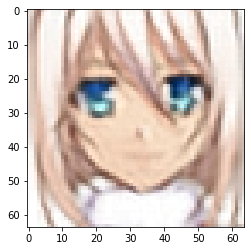

In [15]:
model.eval()
image = Image.open(image_file).convert('RGB') #PIL.Imageで画像の情報を開く。RGBに変換する

image_width = (image.width // scale) * scale
image_height = (image.height //scale) * scale


hr = image.resize((image_width, image_height) , resample=Image.BICUBIC)
# lr = hr.resize( (hr.width // scale, hr.height // scale), resample=Image.BICUBIC)
lr = hr.resize( (hr.width, hr.height), resample=Image.BICUBIC)

bicubic = lr.resize((lr.width * scale,lr.height * scale),resample=Image.BICUBIC)
#bicubic.save(image_file.replace('.', '_bicubic_x{}.'.format(scale)))

lr, _ = preprocess(lr,device)#前処理をする
hr, _ = preprocess(hr,device)
print(hr.shape)
print(lr.shape)
_, ycbcr = preprocess(bicubic, device)

with torch.no_grad():
    preds = model(lr).clamp(0.0,1.0)

# psnr = calc_psnr(hr, preds)
# print('PSNR: {:.2f}'.format(psnr))


preds = preds.mul(255.0).cpu().numpy().squeeze(0).squeeze() #255.0をかける　cpu上にデータを載せる　torch.tensorからnumpy型にする 次元を2つ削除する


output = np.array([preds, ycbcr[...,1],ycbcr[...,2]]).transpose([1,2,0])
#予測した配列と ycbcrのcbチャネルとcrチャネルの配列をoutputの配列にする 
#さらに軸を移動させる (3, 64, 64) => (64, 64, 3)
output = np.clip(convert_ycbcr_to_rgb(output),0.0,255.0).astype(np.uint8)
#NumPy配列ndarrayを最小値・最大値に収める。int型に変換する
#bgrで帰ってくる
output = Image.fromarray(output)
plt.imshow(output)
#output.save(image_file.replace('.', '_fsrcnn_x{}.'.format(scale)))

# このモデルの性能を知りたいならこっち

torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 32, 32])
PSNR: 22.74


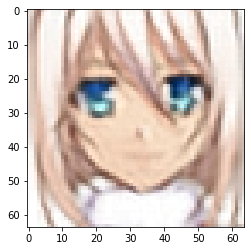

In [18]:
model.eval()
image = Image.open("./create_h5_of_anime-face-datasets/test64x64/12504.png").convert('RGB') #PIL.Imageで画像の情報を開く。RGBに変換する

image_width = (image.width // scale) * scale
image_height = (image.height //scale) * scale


hr = image.resize((image_width, image_height) , resample=Image.BICUBIC)
lr = hr.resize( (hr.width // scale, hr.height // scale), resample=Image.BICUBIC)
#lr = hr.resize( (hr.width, hr.height), resample=Image.BICUBIC)

bicubic = lr.resize((lr.width * scale,lr.height * scale),resample=Image.BICUBIC)
#bicubic.save(image_file.replace('.', '_bicubic_x{}.'.format(scale)))

lr, _ = preprocess(lr,device)#前処理をする
hr, _ = preprocess(hr,device)
print(hr.shape)
print(lr.shape)
_, ycbcr = preprocess(bicubic, device)

with torch.no_grad():
    preds = model(lr).clamp(0.0,1.0)

psnr = calc_psnr(hr, preds)
print('PSNR: {:.2f}'.format(psnr))


preds = preds.mul(255.0).cpu().numpy().squeeze(0).squeeze() #255.0をかける　cpu上にデータを載せる　torch.tensorからnumpy型にする 次元を2つ削除する


output = np.array([preds, ycbcr[...,1],ycbcr[...,2]]).transpose([1,2,0])
#予測した配列と ycbcrのcbチャネルとcrチャネルの配列をoutputの配列にする 
#さらに軸を移動させる (3, 64, 64) => (64, 64, 3)
output = np.clip(convert_ycbcr_to_rgb(output),0.0,255.0).astype(np.uint8)
#NumPy配列ndarrayを最小値・最大値に収める。int型に変換する
#bgrで帰ってくる
output = Image.fromarray(output)
plt.imshow(output)
#output.save(image_file.replace('.', '_fsrcnn_x{}.'.format(scale)))